# Install & Import needed libraries

In [ ]:
!pip install --upgrade datasets sentence-transformers faiss-cpu tqdm --quiet

In [ ]:
!pip install -q python-terrier==0.11.0

In [113]:
from datasets import load_dataset
from tqdm.auto import tqdm
import pandas as pd
import pyterrier as pt
import re
import difflib

In [114]:
if not pt.java.started():
  pt.java.init()

In [70]:
pd.set_option('display.max_colwidth', 150)

# Load dataset

In [ ]:
dataset = load_dataset("FreedomIntelligence/RAG-Instruct", split="train")

print(f"Loaded {len(dataset)} QA pairs.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded 40541 QA pairs.


# Prepare Documents for Indexing
### indexing over column "documents"

In [ ]:

# Flatten all non-empty passages into one list (only if we need to filter out the empty documents)
# documents = []
# for element in dataset:
#     for doc in element['documents']:
#         if doc.strip():  # Only include non-empty passages
#             documents.append(doc)


# Flatten all documents into one big list
documents = []
for element in dataset:
    documents.extend(element['documents'])

# Build a dataframe: docno + text
# Each row needs a unique docno (document number) as required from PyTerrier
docs_df = pd.DataFrame({
    "docno": [str(i) for i in range(len(documents))],
    "text": documents
})


print("Total documents to index:", len(docs_df))
docs_df.head()


Total documents to index: 405410


,docno,text
0,0,"decided to make the story more straightforward, as the novel is very episodic, with Mowgli going back and forth from the jungle to the Man-Village..."
1,1,"and settings. In 2016, a Baloo figure was released for the console and later on mobile versions of ""Disney Infinity 3.0"" (2015), which required a ..."
2,2,"The Jungle Book (franchise) The Jungle Book is a Disney media franchise that commenced in 1967 with the theatrical release of ""The Jungle Book"". I..."
3,3,"and follows her into the Man-Village. After Mowgli chooses to stay in the Man-Village, Baloo and Bagheera decide to head home, content that Mowgli..."
4,4,"creature. So we took some of the distinctive Walken facial features—iconic lines, wrinkles and folds—and integrated them into the animated charact..."


# Index Documents

In [63]:
def create_index(docs_df, index_path='./index'):
    indexer = pt.IterDictIndexer(index_path, overwrite=True, meta={'docno': 20, 'text': 10000})
    indexref = indexer.index(docs_df.to_dict(orient="records"))
    index = pt.IndexFactory.of(indexref)

    # Extract vocabulary from the index
    vocabulary = []
    for entry in index.getLexicon():
        vocabulary.append(entry.getKey())

    return index, vocabulary


In [115]:
index, vocabulary = tqdm(create_index(docs_df), desc="Indexing documents")

15:30:30.979 [ForkJoinPool-9-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (125719) - further warnings are suppressed
15:32:09.665 [ForkJoinPool-9-worker-3] WARN org.terrier.structures.indexing.Indexer -- Indexed 2 empty documents


Indexing documents:   0%|          | 0/2 [00:00<?, ?it/s]

In [58]:
# print(f"Index created with {index.getCollectionStatistics().getNumberOfDocuments()} documents")
# print(f"Vocabulary contains {len(vocabulary)} unique terms")
print(index.getCollectionStatistics().toString())

Number of documents: 405410
Number of terms: 344017
Number of postings: 18452698
Number of fields: 1
Number of tokens: 23406650
Field names: [text]
Positions:   false



# Querying the index (Keyword Search)
use the BM25 score which is known to produce high quality search results.

In [142]:
def query_search(query, top_k=5):
  # Create a BM25 retrieval pipeline
  bm25 = pt.terrier.Retriever(index, wmodel="BM25", metadata=["text"])

  results = bm25.search(query)

  # Ensure we have all required columns
  if len(results) > 0:
      return results[['docid', 'qid', 'rank', 'score', 'text']].head(top_k)
  else:
      return pd.DataFrame(columns=['docid', 'qid', 'rank', 'score', 'text'])

#Tokenization

In [99]:
def tokenize(text):
  #print("started tokenize")
  return re.findall(r'\b\w+\b', text.lower())

In [48]:
# Compute token counts per document
doc_lengths = [len(tokenize(doc)) for doc in docs_df["text"]]
#doc_lengths.count(0)

# Handle misspelling words and typos

In [154]:
def correct_spelling(query, vocabulary, threshold=0.85):
    corrected_tokens = []
    was_corrected = False
    query_tokens = tokenize(query)

    for token in query_tokens:
        # # Skip very short tokens
        # if len(token) < 3:
        #     corrected_tokens.append(token)
        #     continue

        # Try multiple matches to find the best one
        matches = difflib.get_close_matches(token, vocabulary, n=3, cutoff=threshold)

        if matches:
            # Choose the most common term from the matches
            corrected_tokens.append(matches[0])
            if matches[0] != token:
                was_corrected = True
                print(f"Corrected '{token}' to '{matches[0]}'")
        else:
            corrected_tokens.append(token)

    corrected_query = ' '.join(corrected_tokens)
    return corrected_query, was_corrected

# Option to search for exact phrase

In [155]:
def phrase_search(phrase, top_k=10):
    results = []
    phrase_lower = phrase.lower()
    for i, doc_text in enumerate(tqdm(documents, desc="Searching for phrase")):
            if phrase_lower in doc_text.lower():
                results.append({
                    'docid': i,
                    'text': doc_text,
                    'score': 1.0
                })
                if len(results) >= top_k:
                    break

    # Convert to DataFrame
    if results:
        results_df = pd.DataFrame(results)
        results_df['rank'] = range(1, len(results_df) + 1)
        results_df['qid'] = 0
        return results_df
    else:
        return pd.DataFrame(columns=['docid', 'text', 'score', 'rank', 'qid'])

# Search combined with
- correct query tokens/words
- phrase search

In [156]:
def combined_search(query, top_k=10, apply_correction=True, use_phrase_search=False):
    original_query = query

    # Apply spelling correction if requested
    if apply_correction:
        corrected_query, was_corrected = correct_spelling(query, vocabulary)

        # If query was corrected, print the correction
        if was_corrected:
            print(f"Searching for: '{corrected_query}' (corrected from '{original_query}')")
            query = corrected_query
        else:
            print(f"Searching for: '{original_query}'")
    else:
        print(f"Searching for: '{original_query}'")

    results = query_search(query, top_k=top_k)

    # Perform phrase search if requested and merge results
    if use_phrase_search and len(query.split()) > 1:
        phrase_results = phrase_search(query, top_k=top_k)

        if not phrase_results.empty:
            # Merge results, prefer phrase matches by giving them higher scores
            phrase_results['score'] = phrase_results['score'] + 10.0  # Boost phrase match scores

            # Concatenate and remove duplicates, keeping highest score
            all_results = pd.concat([results, phrase_results])
            all_results = all_results.sort_values('score', ascending=False)
            all_results = all_results.drop_duplicates(subset='docid', keep='first')

            # Rerank and return top_k
            all_results['rank'] = range(1, len(all_results) + 1)
            return all_results.head(top_k)

    return results.head(top_k)

# Visualize Results

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display

In [136]:
def highlight_terms(text, query_terms):
    highlighted = text
    for term in query_terms:
        if len(term) < 3:  # Skip highlighting very short terms
            continue
        # Case insensitive replacement with HTML highlighting
        pattern = re.compile(re.escape(term), re.IGNORECASE)
        highlighted = pattern.sub(f'<span style="background-color: yellow">{term}</span>', highlighted)
    return highlighted

In [149]:
def plot_search_results(results, query, top_n=5):
    # Extract data for plotting
    if len(results) == 0:
        print("No results found.")
        return

    # Limit to top_n results
    plot_results = results.head(top_n)

    # Get docids and scores for plotting
    docids = [str(d) for d in plot_results['docid']]
    scores = plot_results['score'].tolist()

    # Create figure and axis objects explicitly
    fig, ax = plt.subplots(figsize=(6, 4))

    # Create horizontal bar chart
    y_pos = np.arange(len(docids))
    ax.barh(y_pos, scores, align='center', color='skyblue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(docids)
    ax.invert_yaxis()  # Labels read top-to-bottom
    ax.set_xlabel('BM25 Score')
    ax.set_ylabel('Document ID')
    ax.set_title(f'Top {top_n} Results for Query: "{query}"')

    plt.tight_layout()
    plt.show()

    # Display text snippets with term highlighting
    print("\nText Snippets (query terms highlighted):")
    query_terms = query.lower().split()

    for i, row in plot_results.iterrows():
        snippet = row['text']
        if len(snippet) > 300:  # Truncate long snippets
            snippet = snippet[:300] + "..."

        # Display with highlighting
        print(f"\nDocument {row['docid']} (Score: {row['score']:.4f}):")
        display(HTML(highlight_terms(snippet, query_terms)))
        print("-" * 80)

# Keyword search Example

In [157]:
# Example
query = "world health"
result = query_search(query, 8)

# Display top 8 results
print(f"Top {len(result)} results for query '{query}':")
result

Top 8 results for query 'world health':


,docid,qid,rank,score,text
0,160123,1,0,17.588294,"support efforts in low-income countries to achieve universal coverage and improve population health outcomes. The theme of the ""World Health Repor..."
1,164953,1,1,16.809846,Mental health in the Middle East The study of mental health in the Middle East is an area of research that continues to grow in its scope and cont...
2,164956,1,2,16.460245,WHO global plan of action for workers' health The World Health Organization's global plan of action for workers' health delineates common principl...
3,293600,1,3,16.455373,"the world according to criteria of the overall level and distribution of health in the populations, and the responsiveness and fair financing of h..."
4,284994,1,4,15.607298,"safe when breastfeeding. Suramin was made at least as early as 1916. It is on the World Health Organization's List of Essential Medicines, the mos..."
5,124128,1,5,15.433985,"(maltitol syrup), and the reduced calorie replacement for conventional fats and oils, salatrim. The fifty third report was released as World Healt..."
6,32913,1,6,15.401937,"that the health consumer is supported in their decisions and actions’. E-health, defined by the World Health Organization as the combined use of e..."
7,257101,1,7,15.373063,might include the capturing of statuses and previously resolved conditions impacting upon the current encounter. For example; a patient with a his...


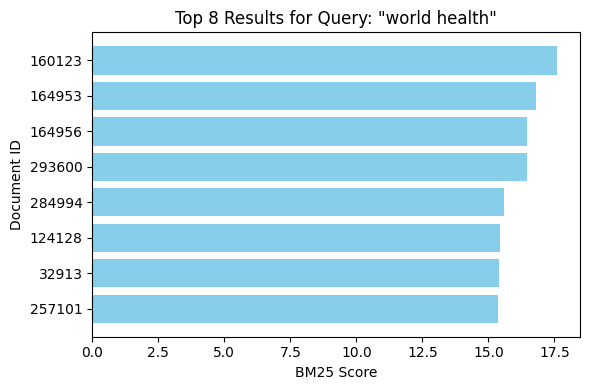


Text Snippets (query terms highlighted):

Document 160123 (Score: 17.5883):


--------------------------------------------------------------------------------

Document 164953 (Score: 16.8098):


--------------------------------------------------------------------------------

Document 164956 (Score: 16.4602):


--------------------------------------------------------------------------------

Document 293600 (Score: 16.4554):


--------------------------------------------------------------------------------

Document 284994 (Score: 15.6073):


--------------------------------------------------------------------------------

Document 124128 (Score: 15.4340):


--------------------------------------------------------------------------------

Document 32913 (Score: 15.4019):


--------------------------------------------------------------------------------

Document 257101 (Score: 15.3731):


--------------------------------------------------------------------------------


In [151]:
plot_search_results(result, query, 8)

# Combined search Examples

In [158]:
# Example 1
query1 = "world helth"
combined_result = combined_search(query1, 8)

print(f"Top {len(combined_result)} results for query '{query1}':")
combined_result

Corrected 'helth' to 'herlth'
Searching for: 'world herlth' (corrected from 'world helth')
Top 8 results for query 'world helth':


,docid,qid,rank,score,text
0,218434,1,0,17.883855,A Mother's Love (1939 film) A Mother's Love or Mother Love (German: Mutterliebe) is a 1939 drama film directed by Gustav Ucicky and starring Käthe...
1,382741,1,1,7.934589,all possibilities. So formula_14 is a world set as either x = 2 (in world formula_8) or x= −2 (in world formula_9). There are no other possibiliti...
2,2287,1,2,7.847061,"that, in comparison with God, the World is actual eminently. ""It is as true to say that the World is immanent in God, as that God is immanent in t..."
3,99401,1,3,7.607957,"Physicalism is false. Here proposition P3 is a direct application of the supervenience of consciousness, and hence of any supervenience-based vers..."
4,13520,1,4,7.590421,"Basic Mid(""Hello, World"",2,1) ' Example in Visual Basic .NET ""Hello, World"".Chars(2) ' ""l""c "" Example in Smalltalk "" 'Hello, World' at: 2. ""$e"" //..."
5,64681,1,5,7.590421,"Basic Mid(""Hello, World"",2,1) ' Example in Visual Basic .NET ""Hello, World"".Chars(2) ' ""l""c "" Example in Smalltalk "" 'Hello, World' at: 2. ""$e"" //..."
6,88155,1,6,7.590421,"Basic Mid(""Hello, World"",2,1) ' Example in Visual Basic .NET ""Hello, World"".Chars(2) ' ""l""c "" Example in Smalltalk "" 'Hello, World' at: 2. ""$e"" //..."
7,106201,1,7,7.590421,"Basic Mid(""Hello, World"",2,1) ' Example in Visual Basic .NET ""Hello, World"".Chars(2) ' ""l""c "" Example in Smalltalk "" 'Hello, World' at: 2. ""$e"" //..."


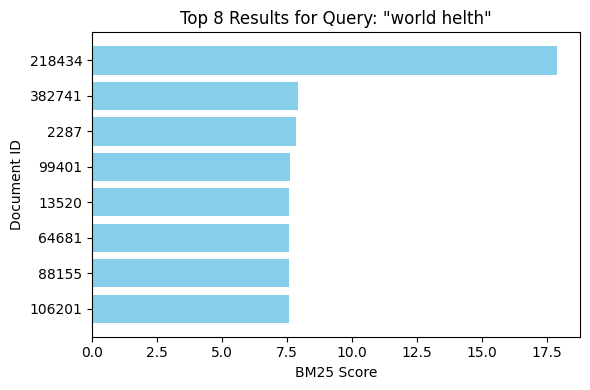


Text Snippets (query terms highlighted):

Document 218434 (Score: 17.8839):


--------------------------------------------------------------------------------

Document 382741 (Score: 7.9346):


--------------------------------------------------------------------------------

Document 2287 (Score: 7.8471):


--------------------------------------------------------------------------------

Document 99401 (Score: 7.6080):


--------------------------------------------------------------------------------

Document 13520 (Score: 7.5904):


--------------------------------------------------------------------------------

Document 64681 (Score: 7.5904):


--------------------------------------------------------------------------------

Document 88155 (Score: 7.5904):


--------------------------------------------------------------------------------

Document 106201 (Score: 7.5904):


--------------------------------------------------------------------------------


In [159]:
plot_search_results(combined_result, query1, 8)

In [160]:
# Example 2
query2 = "world healt"
combined_result = combined_search(query2, 8)

print(f"Top {len(combined_result)} results for query '{query2}':")
combined_result

Corrected 'healt' to 'health'
Searching for: 'world health' (corrected from 'world healt')
Top 8 results for query 'world healt':


,docid,qid,rank,score,text
0,160123,1,0,17.588294,"support efforts in low-income countries to achieve universal coverage and improve population health outcomes. The theme of the ""World Health Repor..."
1,164953,1,1,16.809846,Mental health in the Middle East The study of mental health in the Middle East is an area of research that continues to grow in its scope and cont...
2,164956,1,2,16.460245,WHO global plan of action for workers' health The World Health Organization's global plan of action for workers' health delineates common principl...
3,293600,1,3,16.455373,"the world according to criteria of the overall level and distribution of health in the populations, and the responsiveness and fair financing of h..."
4,284994,1,4,15.607298,"safe when breastfeeding. Suramin was made at least as early as 1916. It is on the World Health Organization's List of Essential Medicines, the mos..."
5,124128,1,5,15.433985,"(maltitol syrup), and the reduced calorie replacement for conventional fats and oils, salatrim. The fifty third report was released as World Healt..."
6,32913,1,6,15.401937,"that the health consumer is supported in their decisions and actions’. E-health, defined by the World Health Organization as the combined use of e..."
7,257101,1,7,15.373063,might include the capturing of statuses and previously resolved conditions impacting upon the current encounter. For example; a patient with a his...


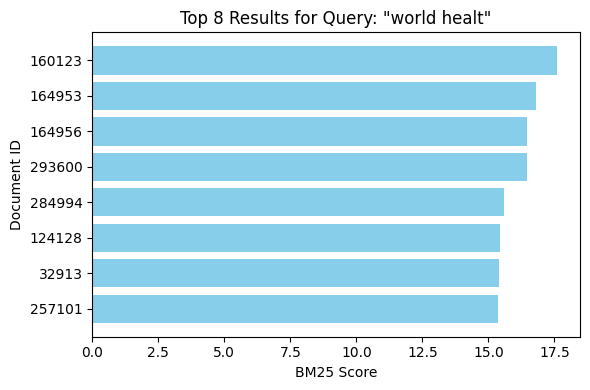


Text Snippets (query terms highlighted):

Document 160123 (Score: 17.5883):


--------------------------------------------------------------------------------

Document 164953 (Score: 16.8098):


--------------------------------------------------------------------------------

Document 164956 (Score: 16.4602):


--------------------------------------------------------------------------------

Document 293600 (Score: 16.4554):


--------------------------------------------------------------------------------

Document 284994 (Score: 15.6073):


--------------------------------------------------------------------------------

Document 124128 (Score: 15.4340):


--------------------------------------------------------------------------------

Document 32913 (Score: 15.4019):


--------------------------------------------------------------------------------

Document 257101 (Score: 15.3731):


--------------------------------------------------------------------------------


In [161]:
plot_search_results(combined_result, query2, 8)

# Phrase search Example

Searching for phrase:   0%|          | 0/405410 [00:00<?, ?it/s]

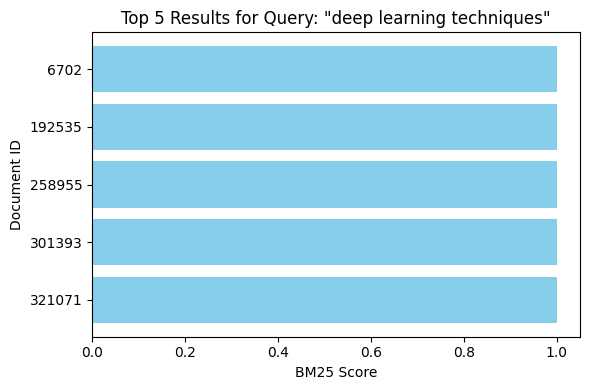


Text Snippets (query terms highlighted):

Document 6702 (Score: 1.0000):


--------------------------------------------------------------------------------

Document 192535 (Score: 1.0000):


--------------------------------------------------------------------------------

Document 258955 (Score: 1.0000):


--------------------------------------------------------------------------------

Document 301393 (Score: 1.0000):


--------------------------------------------------------------------------------

Document 321071 (Score: 1.0000):


--------------------------------------------------------------------------------


In [163]:
phrase_query = "deep learning techniques"
phrase_results = phrase_search(phrase_query, 5)
plot_search_results(phrase_results, phrase_query, 5)